# Mean Absolute Error (MAE)

In [2]:
from scores.continuous import mae

help(mae)

Help on function mae in module scores.continuous:

mae(forecast, observed, reduce_dims=None)
    Returns a single floating point number representing the mean absolute
    error for the supplied data. All dimensions will be reduced.
    
    If reduce_dims is specified, the method will use xarray calculate the mean along
    that dimension and preserve remaining dimensions in the return result.
    
    Dimensional reduction is not supported for pandas and the user should
    convert their data to xarray to formulate the call to the metric.
    
    A detailed explanation is on [Wikipedia](https://en.wikipedia.org/wiki/Mean_absolute_error)



In [3]:
import numpy
import xarray

In [6]:
forecast = xarray.open_dataset('forecast_grid.nc')
analysis = xarray.open_dataset('analysis_grid.nc')

# Spatial Structure of Change
The example forecast provides ten days of predictions. We will start by doing something a little surprising - which is looking at the mean absolute error of the forecast at all lead times, compared to the first predicted hour. While this reduces the time dimension, and says nothing about accuracy compared to observations, it does allow the visualisation of the spatial structure of change within the prediction. Areas with a low error change little throughout the period, whereas areas of high error show which parts of the globe change significantly through the period.

This answers the question "over the next ten days, which parts of the earth are likely to experience the greatest changes in temperature on average".

In this image, the effect of the land masses can be clearly seen, showing that temperature over land changes differently to temperature over the ocean.

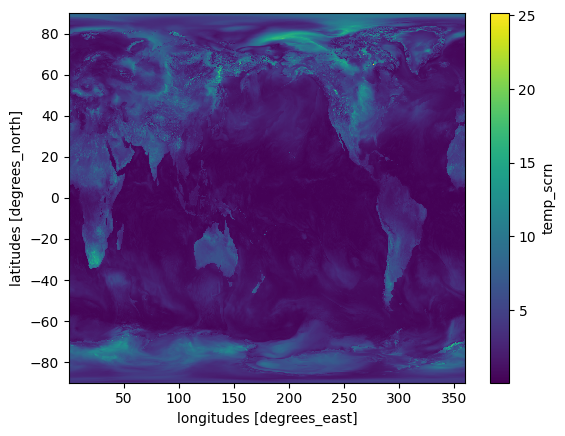

In [8]:
# Figure One - Mean Absolute Error of Predictions
mae(forecast.temp_scrn,forecast.temp_scrn[0], reduce_dims='time').plot()

# Matching the Forecast Lead Time and to Observations

It's to be expected that a forecast for tomorrow isn't going to match the conditions in four days time, or the conditions in ten days time. To check whether a forecast is accurate, we need to match up the observations (here taken from the analysis grid - an explanation of which is out of scope for this tutorial) with the matching time from a previous forecast to see how things turned out. To do this, we need to introduce a few terms based on how a forecast model works.

A forecast model takes into account recent observations, and then predicts forward. The time at which observations cease to be included and the actual computation is done is called the *base time*. The model predicts forward in time. There is typically some interval, often one hour, between the base time and the start of the predictions. The validity start time defines the time for which the first prediction is made. The validity end time defines the farthest time into the future for which a prediction is made. For any particular time within that range, the lead time is the time since the base time.

In this example, the base time for the forecast data (if using the downloaded data) can be found in the metadata as 20th November 2022, at 0Z UTC. The model was run at midnight and its first predicted hour is for 1am UTC on the 20th of November 2022. If using synthetic data, it does not include the base time in its metadata but the validity period is the same.

In [9]:
# The validity period extends from 1am on the 20th of November 2022, to the 30th of November 2022.
print(min(forecast.time).values)
print(max(forecast.time).values)

2022-11-20T01:00:00.000000000
2022-11-30T00:00:00.000000000


The analysis time is the 24th of November at 0Z UTC. This is four days into the forecast period and has a lead time of 96 hours. We now want to find the forecast time step from the previous forecast run which lines up with this analysis time.

In [10]:
print(analysis.time.values)

['2022-11-24T00:00:00.000000000']


In [11]:
print(forecast.time[24*4-1].values)  # The minus one is to allow for the hour between the base time and the validity start time.

2022-11-24T00:00:00.000000000


In [12]:
time_step_of_interest = forecast.temp_scrn[24*4-1]
time_step_of_interest

<xarray.DataArray 'temp_scrn' (lat: 1536, lon: 2048)>
[3145728 values with dtype=float32]
Coordinates:
    time     datetime64[ns] 2022-11-24
  * lat      (lat) float64 89.94 89.82 89.71 89.59 ... -89.71 -89.82 -89.94
  * lon      (lon) float64 0.08789 0.2637 0.4395 0.6152 ... 359.6 359.7 359.9
Attributes:
    grid_type:   spatial
    level_type:  single
    units:       K
    long_name:   screen level temperature
    stash_code:  3236
    accum_type:  instantaneous

We now have the matching forecast and observation. If we plot them, they look pretty similar!

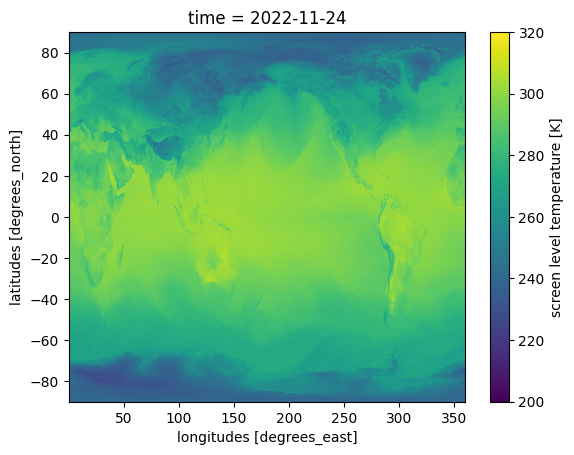

In [13]:
time_step_of_interest.plot(vmin=200, vmax=320)

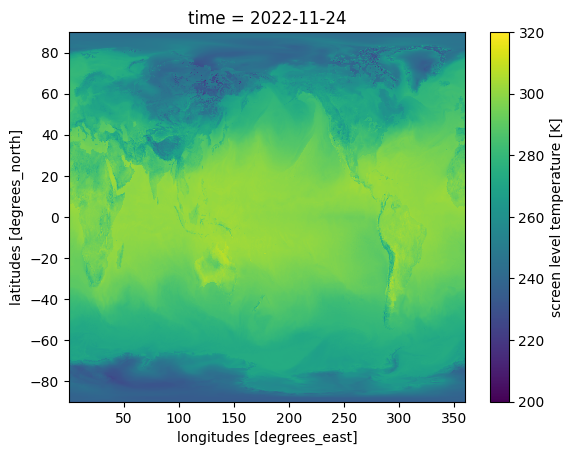

In [14]:
analysis.temp_scrn.plot(vmin=200, vmax=320)


This close similarity means it is hard to pick out differences by eye alone. Scores and metrics can reveal issues and patterns. First we calculate the aggregate error for the entire planet as a single number.

In [16]:
mae(time_step_of_interest, analysis.temp_scrn)

<xarray.DataArray 'temp_scrn' ()>
array(1.4504522, dtype=float32)

This is interesting, but also raises questions. A forecast for four days ahead which is only about a degree and a half wrong sounds pretty impressive. But what about all that spatial structure we saw earlier? As seen in Figure One, we saw that the conditions didn't generally change as much over the ocean, so cities are likely to have an above average expected error. Mean absolute error can be used in other ways to investigate that question. 

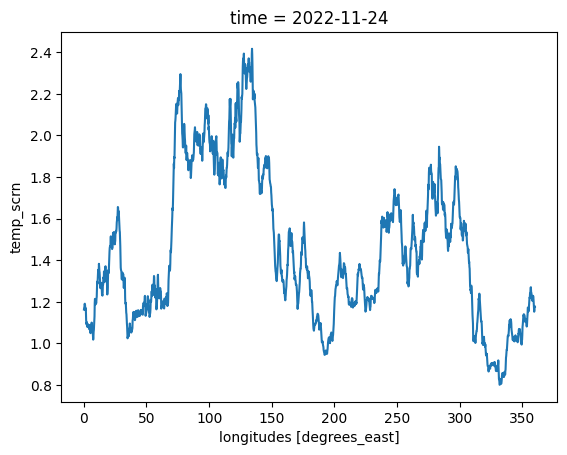

In [17]:
mae_by_longitude = mae(time_step_of_interest, analysis.temp_scrn, reduce_dims='lat')
mae_by_longitude.plot()

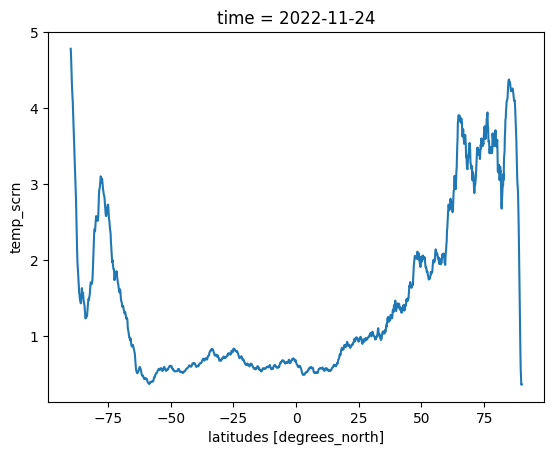

In [18]:
mae_by_latitude = mae(time_step_of_interest, analysis.temp_scrn, reduce_dims='lon')
mae_by_latitude.plot()

We can quickly see here that forecast errors generally increase towards the poles. Subsetting the data to between +/- 50 degrees latitude could reveal a different story. Further analysis can be done by examining specific geographic areas of interest (such as countries, mountainous areas, or other types of spatial query).

An additional point to be aware of is the different amount of real area represented by each point on this grid. Due to the way that the projection of the earth onto a rectangular grid works, the mid-latitudes represent a much larger amount of area than the polar latitudes. A common approach is to calculate a latitude-weighted score to take account of this effect.

Mean absolute error can also be used as a training or objective function for machine learning.